In [1]:
shape_cat="mcal"
vol="vlim"
z_range="all_z"
key=""
quantile=""
test=""
z_diff=""

In [2]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import fitsio as fio
import numpy as np
import ast

import astropy.cosmology
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from IPython.display import display, Math
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
#This header file contains all the common packages
%matplotlib inline
%run -i header.py $shape_cat $vol $z_range 
%run -i func.py  

In [4]:
BPZ_table=Table(fits.open('/lsst/troxel/y1a1/mcal-y1a1-combined-griz-blind-v3-matched_BPZbase.fits')[1].data)

In [5]:
BPZ_table

template_id,coadd_objects_id,r11,r22,template_type,median_z,mean_z,minchi2,mode_z,z_sigma68,z_sigma,kl_post_prior,z_mc
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
24,3007825738,0.34419721337254455,0.7797333138830541,2.6666666666666665,0.5877911726071515,0.5924987689164418,1.0369240172085483,0.59,0.021323520502312843,0.029561286126199307,2.1855233372462246,0.6002927486379405
12,3007825739,0.42446256532802235,0.9309083875559503,1.3333333333333333,1.1253882294802928,1.1448296848132031,1.3296750399402413,1.1,0.10571546589672931,0.13225376095756353,1.4916991224401337,1.199187001030529
-999,3007825740,-9999.0,-9999.0,nan,nan,nan,nan,nan,nan,nan,nan,nan
0,3007825741,-0.3458804781852995,-0.8582562267378256,0.0,1.7011487212816951,1.707580413967189,18.250247076419214,1.69,0.06679824049968064,0.08433142355939317,2.7375563687735474,1.679424380744105
27,3007825742,0.7252602691592988,0.6394488945126897,3.0,0.5205978402465985,0.4933850080160066,0.8984133269614176,0.54,0.051618966840527136,0.08961329125754196,1.327558988249807,0.4483999125373314
0,3007825743,0.04798363296142777,-0.15751114893393023,0.0,0.7581173882531212,0.7663845608564833,7.1800122975606655,0.77,0.06709741900835586,0.07170692747900025,1.3478543567883392,0.6842515468023642
15,3007825744,-0.21488057127988305,-1.2586116959823124,1.6666666666666665,0.9263041353840054,0.9628493798941085,0.3287888709393769,0.85,0.1808643177650735,0.2330704206459537,0.5058619184796762,0.6104984912325317
5,3007825745,2.0515732304151912,1.490275053383235,0.5555555555555556,0.7237060362467485,0.7217561076016299,0.017370651534065473,0.74,0.07021215734153663,0.06608050328312412,1.314694314191227,0.7477558565487331
19,3007825746,0.17234656276413768,1.1723058467189156,2.111111111111111,1.0698524035721073,1.0858594236968515,0.2337819316916807,1.12,0.20365738447860215,0.2276165085534737,0.6946623862759298,1.130480303599848


In [6]:
BPZ_table=BPZ_table[['mean_z','coadd_objects_id']]

In [7]:
BPZ_half=BPZ_table.to_pandas()
BPZ_table=None

In [8]:
mcal = fio.FITS('/lsst/troxel/y1a1/mcal-y1a1-combined-riz-unblind-v4-matched.fits',memmap=True,mode='r')[1]
mcal_id=mcal['coadd_objects_id'][:] 

In [9]:
mcal


  file: /lsst/troxel/y1a1/mcal-y1a1-combined-riz-unblind-v4-matched.fits
  extension: 1
  type: BINARY_TBL
  rows: 136930995
  column info:
    coadd_objects_id
                        i8  
    flags               i4  
    mask_frac           f8  
    psf_e1              f8  
    psf_e2              f8  
    psf_size            f8  
    mcal_psf_e1         f8  
    mcal_psf_e2         f8  
    mcal_psf_size       f8  
    e1                  f8  
    e1_1p               f8  
    e1_1m               f8  
    e1_2p               f8  
    e1_2m               f8  
    e2                  f8  
    e2_1p               f8  
    e2_1m               f8  
    e2_2p               f8  
    e2_2m               f8  
    size                f8  
    size_1p             f8  
    size_1m             f8  
    size_2p             f8  
    size_2m             f8  
    size_err            f8  
    size_err_1p         f8  
    size_err_1m         f8  
    size_err_2p         f8  
    size_err_2m         f8

In [10]:
BPZ_half.set_index("coadd_objects_id",inplace=True)

In [11]:
BPZ_id=BPZ_half.index.to_numpy()
shapes_id=shapes.index.to_numpy()

In [12]:
i_mcal,i_BPZ=sort2n(mcal_id,BPZ_id)

In [13]:
mcal_half=pd.DataFrame(mcal.read(rows=[i_mcal],columns=['coadd_objects_id','ra','dec','e1','e2','flags_select']).byteswap().newbyteorder())
mcal_columns=mcal_half.columns
mcal_product_col=pd.MultiIndex.from_product([['All'],mcal_columns],names=['Band','Data'])
mcal_half.columns=mcal_product_col
mcal_half[('All','RA')]=mcal_half[('All','ra')]
mcal_half[('All','DEC')]=mcal_half[('All','dec')]
mcal_half.drop(columns=[('All','ra'),('All','dec')],inplace=True)
mcal_half.set_index(('All','coadd_objects_id'),inplace=True)

In [14]:
BPZ_columns=BPZ_half.columns.to_list()
BPZ_product_col=pd.MultiIndex.from_product([['All'],BPZ_columns],names=['Band','Data'])
BPZ_half.columns=BPZ_product_col

In [15]:
drop_columns=[('All',column) for column in BPZ_columns if column!='mean_z']
BPZ_half.drop(columns=drop_columns,inplace=True)

In [16]:
assert len(BPZ_half)==len(mcal_half)

In [17]:
mcal_half.sort_index(inplace=True)
BPZ_half.sort_index(inplace=True)

In [18]:
assert np.all(mcal_half.index==BPZ_half.index)
mcal_half[('All','mean_z')]=BPZ_half[('All','mean_z')]

In [19]:
BPZ=mcal_half
BPZ.index.name="ID"

In [20]:
BPZ_half=None
mcal_half=None

# BPZ&shape

In [21]:
i_BPZ,i_shapes=sort2n(BPZ_id,shapes_id)

In [22]:
help(sort2n)

Help on function sort2n in module __main__:

sort2n(x, y)
    Sorts and matches two arrays of object ids where x is unique and y is not (in DES this is coadd_objects_id).
    Slower than sort2().



In [23]:
BPZ_half=BPZ.iloc[i_BPZ]

In [24]:
BPZ_half.drop([('All',           'RA'),
            ('All',          'DEC'),
            ('All',           'e1'),
            ('All',           'e2'),
            ('All', 'flags_select')],inplace=True,axis=1)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2019_23/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [25]:
shape_BPZ=pd.concat([shapes,BPZ_half],axis=1,verify_integrity=True)

In [26]:
# This looks like a suspicious criterion to select memebers

members=shape_BPZ[(shape_BPZ[('All','Z')]-shape_BPZ[('All','mean_z')])<=-0.1]

In [27]:
shape_BPZ.columns

MultiIndex(levels=[['All', 'g', 'i', 'r', 'z'], ['CHISQ', 'DEC', 'EBV', 'MEM_MATCH_ID', 'MODEL_MAG', 'MODEL_MAGERR', 'P', 'PFREE', 'PP', 'R', 'R11', 'R12', 'R21', 'R22', 'RA', 'REFMAG', 'REFMAG_ERR', 'REFMAG_FIT', 'REFMAG_FIT_E', 'R_LAMBDA', 'THETA_I', 'THETA_R', 'Theta_cen', 'Theta_sat', 'Z', 'ZMAG', 'ZMAG_ERR', 'ZRED', 'ZRED2', 'ZRED2_E', 'ZRED_E', 'ZSPEC', 'alpha', 'angR', 'covmat_0_0', 'covmat_0_0_1m', 'covmat_0_0_1p', 'covmat_0_0_2m', 'covmat_0_0_2p', 'covmat_0_1', 'covmat_0_1_1m', 'covmat_0_1_1p', 'covmat_0_1_2m', 'covmat_0_1_2p', 'covmat_1_1', 'covmat_1_1_1m', 'covmat_1_1_1p', 'covmat_1_1_2m', 'covmat_1_1_2p', 'dec', 'e', 'e1', 'e1_1m', 'e1_1p', 'e1_2m', 'e1_2p', 'e2', 'e2_1m', 'e2_1p', 'e2_2m', 'e2_2p', 'ep', 'ex', 'flags', 'flags_select', 'flags_select_1m', 'flags_select_1p', 'flags_select_2m', 'flags_select_2p', 'flux_err_i', 'flux_err_r', 'flux_err_z', 'flux_i', 'flux_i_1m', 'flux_i_1p', 'flux_i_2m', 'flux_i_2p', 'flux_r', 'flux_r_1m', 'flux_r_1p', 'flux_r_2m', 'flux_r_2p', 

In [28]:
len(members)/len(BPZ)

0.00023640374482052074

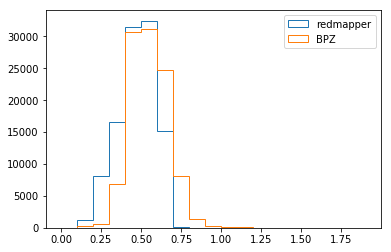

In [29]:
BINS=np.arange(0,2,0.1)
plt.hist(shape_BPZ[('All','Z')],histtype="step",label="redmapper",bins=BINS)
plt.hist(shape_BPZ[('All','mean_z')],histtype="step",label="BPZ",bins=BINS)
plt.legend()

Text(0, 0.5, 'BPZ')

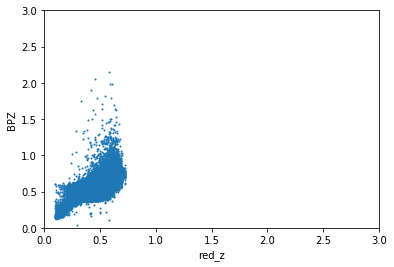

In [30]:
plt.scatter(shape_BPZ[('All','Z')],shape_BPZ[('All','mean_z')],s=1,)
# plt.axis('equal')
plt.xlim(0,3)
plt.ylim(0,3)
plt.xlabel("red_z")
plt.ylabel("BPZ")

In [31]:
len(shape_BPZ[('All','mean_z')])

105029

In [32]:
shapes[('All','ZRED2')].describe()

count    105029.000000
mean          0.470596
std           0.118353
min           0.069967
25%           0.391294
50%           0.479863
75%           0.560855
max           0.947782
Name: (All, ZRED2), dtype: float64

# Masking &saving

In [33]:
BPZ=BPZ[BPZ['All','flags_select']==0]
BPZ.dropna(axis=0,how='any',inplace=True)

In [34]:
np.any(np.isnan(BPZ[('All','mean_z')]))

False

In [35]:
H0=100 #km s-1 Mpc-1
Om0=0.3
Ode0=0.7
lcdm=astropy.cosmology.FlatLambdaCDM(H0, Om0)

In [36]:
BPZ[('All','angR')]=BPZ.progress_apply(lambda x:np.float(lcdm.angular_diameter_distance(x[('All','mean_z')])/u.Mpc),axis=1)

In [37]:
shape_BPZ.to_pickle("/home/adt35/des_y1_catalog/sa-master/data/shape_BPZ.pkl")
BPZ.to_pickle("/home/adt35/des_y1_catalog/sa-master/data/BPZ.pkl")